# Developing a Trading Algorithm with Open Source Python
### By Gus Gordon of [Quantopian](https://www.quantopian.com/)

### Disclaimer

<span style="font-size:12px;line-height:100%">This material is provided for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation or endorsement for any security or strategy, nor does it constitute an offer to provide investment advisory services by Quantopian. In addition, the material offers no opinion with respect to the suitability of any security or specific investment. No information contained herein should be regarded as a suggestion to engage in or refrain from any investment-related course of action as none of Quantopian nor any of its affiliates is undertaking to provide investment advice, act as an adviser to any plan or entity subject to the Employee Retirement Income Security Act of 1974, as amended, individual retirement account or individual retirement annuity, or give advice in a fiduciary capacity with respect to the materials presented herein. If you are an individual retirement or other investor, contact your financial advisor or other fiduciary unrelated to Quantopian about whether any given investment idea, strategy, product or service described herein may be appropriate for your circumstances. All investments involve risk, including loss of principal. Quantopian makes no guarantees as to the accuracy or completeness of the views expressed in this presentation. The views are subject to change, and may have become unreliable for various reasons, including changes in market conditions or economic circumstances.</span>

How can one develop their own algorithmic trading strategy?
 * Use a platform like [Quantopian](https://www.quantopian.com/)
 * Build your own tools (time consuming!)
 * Use open source tools

This is a walkthrough of how one might develop a trading strategy using open source Python tools.

## Investment hypothesis
When developing a trading strategy, we have to start with some sort of idea or hypothesis.

<img src="files/study1.png" style="display:inline-block;width:49%"/> <img src="files/study2.png" style="display:inline-block;width:49%"/>

Building on top of these studies, our algorithm will take rainfall at a given company's headquarters as a signal.

Our hypothesis is that recent rainfall at a company's headquarters has an effect on that company's stock price.

<img src="http://i1.manchestereveningnews.co.uk/incoming/article783233.ece/ALTERNATES/s615/C_71_article_1313868_image_list_image_list_item_4_image.jpg" style="display:inline-block;width:35%;margin-left:9%;margin-right:5%"/><img src="https://fthmb.tqn.com/8YT9Loi31ImRcdzsqriu1Ichz9g=/3259x3058/filters:no_upscale():fill(transparent,1)/about/Interest-Rates-and-Asset-Prices-56a093873df78cafdaa2da15.jpg" style="display:inline-block;width:35%;margin-left:5%;margin-right:9%"/>

We'll start off by gathering all the data we need:
 * Company tickers
 * Rainfall data
 * Pricing data

Then, we can:
 * Investigate the "rainfall" signal with [alphalens](github.com/quantopian/alphalens)
 * Create an algorithm with [zipline](github.com/quantopian/zipline)
 * Analyze the resulting backtest with [pyfolio](github.com/quantopian/pyfolio)

## Gathering required data

<br />
<div class="alert alert-warning">
This part is a little laborious — feel free to skip ahead if you're mostly interested in the tools we're using.
</div>

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.display import HTML, display
display(HTML('<style>table {font-size: 100% !important}</style>')) # Larger tables

from traitlets.config.manager import BaseJSONConfigManager
path = "~/miniconda3/envs/rise_latest/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {'scroll': True});

### Getting the S&P 500
To get the historic S&P 500, we can use [this repo on GitHub](https://github.com/datasets/s-and-p-500-companies/) that logs the S&P 500. For 2015 onwards, we'll take the constituents once at the start of each year to avoid [survivorship bias](https://en.wikipedia.org/wiki/Survivorship_bias).

In [2]:
sp500_sources = {
    2015: 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/b53dc16918f30c3baf534113539b7bc60d336581/data/constituents-financials.csv',
    2016: 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/d27db1c2dcf039c72a3cceb60ac7ebb9d090e1c3/data/constituents-financials.csv',
    2017: 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/5bfe9b141ffee903c741b7f2c16ce050cb1cb324/data/constituents-financials.csv'
}

sp500 = {}
for year, url in sp500_sources.items():
    sp500[year] = pd.read_csv(url).Symbol.tolist()
    sp500[year] = [x.replace('-', '_').replace('.', '__') for x in sp500[year]] # Format some symbols

In [3]:
sp500_symbols = set([x for b in sp500.values() for x in b]) # Unique symbols ever in the S&P 500

### Getting company locations
For each company in the S&P 500, we need the address of the company's headquarters to get the nearby precipitation history.

We need some way to look up the headquarters' geographic coordinates, which are scattered around the US. For each ticker symbol, we first look up the company's address from the Securities and Exchange Commission or, if that fails, Bloomberg.

In [4]:
import requests

def get_company_address(symbol, offset=4):
    try:
        page = requests.get('http://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=' + symbol)
        city_zip = page.text.split('<span class="mailerAddress">')[offset].split('</span>')[0].strip()
        zipcode = city_zip.split(' ')[-1]
        if zipcode.replace('-', '').isdigit() or offset < 3:
            address = city_zip.split(' ')[-1] + ' United States'
        else:
            address = get_company_address(symbol, offset=offset - 1)

    except:
        page = requests.get('https://www.bloomberg.com/quote/' + symbol + ':US')
        address = page.text.split('<br>United States </div>')[0].split('<br>')[-1].strip()

    return address

In [5]:
import geopy
import tqdm # Display a nice progress bar
geolocator = geopy.geocoders.Nominatim()

company_locations = []
for symbol in tqdm.tqdm_notebook(list(sp500_symbols)):
    while True:
        try:
            address = get_company_address(symbol)
            location = geolocator.geocode(address)
            company_locations.append({
                'symbol': symbol,
                'latitude': location.latitude,
                'longitude': location.longitude
            })
            break
        except Exception as e:
            if isinstance(e, geopy.exc.GeocoderTimedOut):
                continue
            else:
                break

company_locations = pd.DataFrame(company_locations).set_index('symbol')
company_locations = company_locations[(company_locations.latitude > 0) & (company_locations.longitude < 0)]

That address then gets plugged into [geopy](https://github.com/geopy/geopy), which is a sleek library that can convert addresses to coordinates. A DataFrame stores the mapping from symbol to latitude and longitude.

In [6]:
company_locations.head()

,latitude,longitude
symbol,,
WU,39.580631,-104.880851
AYI,33.798033,-84.388196
TDG,41.505895,-81.680885
NRG,40.344118,-74.689625
CVX,37.757977,-121.957243


### Getting US weather stations
The NOAA (National Oceanic and Atmospheric Administration) stores US weather stations and weather data on [their website](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/).

Here, we'll pull in a list of official US station IDs with their respective latitudes and longitudes.

We can then use these coordinates to get the closest weather station to each S&P 500 company's headquarters, which we also have the geographic location of.

In [7]:
weather_stations = pd.read_csv('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt',
                               delim_whitespace=True, error_bad_lines=False, warn_bad_lines=False,
                               names=['ID', 'latitude', 'longitude',
                                      'a', 'b', 'c', 'd', 'e'])[['ID', 'latitude', 'longitude']] # Hack

weather_stations = weather_stations[weather_stations.ID.str.startswith('USW')].set_index('ID')

In [8]:
weather_stations.head()

,latitude,longitude
ID,,
USW00003013,38.0700,-102.6881
USW00003016,39.5264,-107.7264
USW00003017,39.8328,-104.6575
USW00003024,35.6950,-101.3950
USW00003026,39.2447,-102.2842


### Visualization of weather stations and company HQs
We can draw a US map using matplotlib's Basemap package, then plot stations and HQs.

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

def show_company_station_map(weather_stations, company_locations):
    plt.figure(figsize=(14, 8))
    map = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
                  projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

    map.readshapefile('st99_d00', name='states', drawbounds=True)

    state_names = []
    for shape_dict in map.states_info:
        state_names.append(shape_dict['NAME'])

    # Add legend
    l1 = map.plot(0, 0, 'bo', markersize=6, color='blue')
    l2 = map.plot(0, 0, 'X', markersize=11, color='red')
    plt.legend(['Weather station', 'S&P 500 HQ'])
    l1.pop(0).remove()
    l2.pop(0).remove()

    # Add points
    for row in weather_stations.iterrows():
        x, y = map(row[1].longitude, row[1].latitude)
        s = map.plot(x, y, 'bo', markersize=6, color='blue', alpha=0.6)

    for row in company_locations.iterrows():
        x, y = map(row[1].longitude, row[1].latitude)
        c = map.plot(x, y, 'X', markersize=11, color='red', alpha=0.6)

    plt.show()

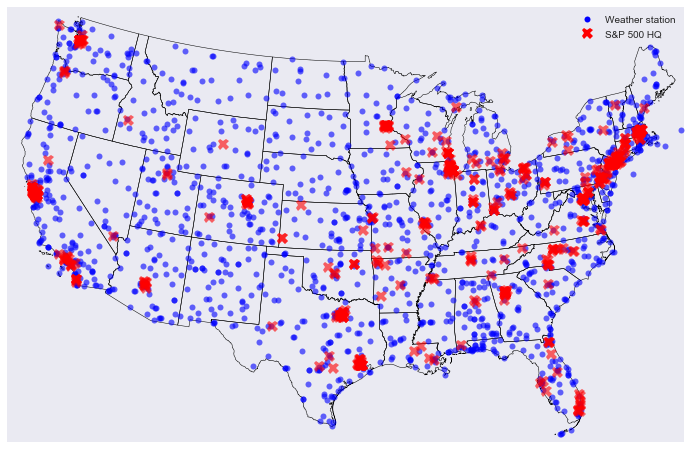

In [29]:
show_company_station_map(weather_stations, company_locations)

### Getting the the weather at each company's headquarters
Map each company to its nearest weather station, then grab the rainfall at that station.

Now that we have a list of available weather stations and locations, along with company names and locations, we can map each company to its nearest weather station with rainfall readings, then grab the weather at that station.

In [11]:
def get_station_precipitation(station_id):
    weather_rows = pd.read_csv('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/all/' + station_id + '.dly',
                       names=['row']).row

    monthly_series = []
    for row in weather_rows:
        if 'PRCP' in row: # Each row is a sequence of characters that log a given month's rainfall
            year = int(row[11:15])
            month = int(row[15:17])
            if year < 2014: # Start a year early so we can get rolling means
                continue

            values = []
            i = 21
            for _ in range(31):
                value = row[i:(i + 5)]
                if len(value) > 0:
                    values.append(float(value))
                    i += 8
                else:
                    break

            month_start = pd.Timestamp(str(year) + '-' + str(month) + '-01')
            index = pd.date_range(month_start, month_start + pd.DateOffset(months=1, days=-1))
            monthly_series.append(pd.Series(data=values[:len(index)], index=index))

    return pd.concat(monthly_series).replace(-9999, np.nan).abs() # -9999 means missing value

In [12]:
symbol_hq_precipitation = {}
for row in tqdm.tqdm_notebook(company_locations.iterrows(), total=len(company_locations)):
    lat, lon = row[1].latitude, row[1].longitude
    station_distances = (weather_stations.latitude - lat) ** 2 + (weather_stations.longitude - lon) ** 2
    station_distances = station_distances.sort_values()

    for station in station_distances.index: # Iterate through nearest stations
        try:
            precip_series = get_station_precipitation(station) # Get historical rainfall
            nan_fraction = precip_series.isnull().sum() / len(precip_series)
            if nan_fraction < 0.1: # If > 10% NaN, use the next closest station
                symbol_hq_precipitation[row[0]] = precip_series
                break
        except:
            continue

symbol_hq_precipitation = pd.DataFrame(symbol_hq_precipitation).dropna(how='all')

### Weather at each company's headquarters
Here's some sample data. The units here are tenths of millimeters of rain:

In [13]:
symbol_hq_precipitation.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ACN,ACT,ADBE,...,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZMH,ZTS
2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,13.0,0.0
2014-01-02,0.0,84.0,0.0,28.0,0.0,0.0,61.0,53.0,36.0,0.0,...,0.0,64.0,15.0,20.0,84.0,53.0,3.0,0.0,3.0,36.0
2014-01-03,0.0,74.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,...,0.0,8.0,10.0,13.0,74.0,0.0,0.0,0.0,0.0,3.0
2014-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0
2014-01-05,0.0,36.0,0.0,28.0,0.0,0.0,51.0,5.0,0.0,0.0,...,0.0,107.0,13.0,20.0,36.0,147.0,74.0,0.0,74.0,0.0


### Get required pricing data
In this step, we load pricing data. Pricing data is required for all the analyses that follow. To get this, we first attempt to load the data through Yahoo. If that fails, we fall back to Google. This pricing data is then stored in a DataFrame.

In [14]:
import pandas_datareader.data as web

pricing = {}
for symbol in sp500_symbols:
    try:
        closes = web.DataReader(symbol, "yahoo", '2015-01-02')['Adj Close']
    except:
        try:
            closes = web.DataReader(symbol, "google", '2015-01-02')['Close']
        except:
            continue
    closes = closes[~closes.index.duplicated(keep='first')] # Remove duplicate index
    pricing[symbol] = closes

pricing = pd.DataFrame(pricing)

In [15]:
# Remove any stocks with crazy values
pricing = pricing.drop(pricing.columns[(pricing.pct_change().min() <= -1.0) |
                                       (pricing.pct_change().max() >= 1.0)], axis=1)

### Sample pricing data

In [16]:
pricing.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,...,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,39.599667,37.242073,52.628891,158.015579,104.274353,60.207584,87.184685,42.353512,83.447441,72.339996,...,85.100090,51.93,33.906784,36.686729,50.169998,49.247585,110.486443,27.688194,112.59,42.398491
2015-01-05,38.857655,35.084465,52.599606,155.932785,101.336784,59.074516,86.442589,42.362938,82.038490,71.980003,...,82.771591,51.57,33.167000,34.403450,49.130001,48.246986,114.607964,26.650743,116.79,42.143963
2015-01-06,38.252335,35.342445,51.779564,155.823151,101.346321,58.782112,86.914841,41.881866,81.446739,70.529999,...,82.331558,50.93,32.723125,34.201130,49.209999,47.654789,113.636482,25.632866,115.80,41.732796
2015-01-07,38.760025,36.257072,51.750271,159.171600,102.767426,61.157890,88.649666,42.221447,83.156273,71.110001,...,83.165787,52.25,33.142345,34.470875,48.590000,49.233978,116.462662,25.877544,118.68,42.594276
2015-01-08,39.921852,37.288967,52.384827,160.566788,106.715965,61.797520,88.852051,43.089268,84.424316,72.919998,...,84.550049,53.54,34.054745,34.731007,50.230000,50.091640,117.699135,26.239676,119.94,43.250179


We'll also create a "testing" set for pricing. By witholding some data, we can play with the strategy and reduce the risk of overfitting ([cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

In [17]:
pricing_test = pricing[:'2017-01-01'].copy()

## Generate our trading signal

We'll use the 3-month rolling mean of daily rainfall, then normalize that for each stock. This is a choice that will likely need tuning.

We can make our trading signal whatever we want. Since earnings reports are quarterly, it might make sense that companies' performances would depend on the weather in the past three months. For example, maybe employees at the headquarters are more productive during sunnier times, which would be reflected in the earnings reports.


In [27]:
sp500_daily_rainfall_3mo = symbol_hq_precipitation.rolling(window=91).mean()
sp500_daily_rainfall_3mo = sp500_daily_rainfall_3mo / sp500_daily_rainfall_3mo.max()
sp500_daily_rainfall_3mo['2016-01-01':].head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ACN,ACT,ADBE,...,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZMH,ZTS
2016-01-01,0.353379,0.475429,0.885659,0.662493,0.339818,NaN,0.464326,0.623388,NaN,0.353379,...,0.885659,NaN,0.504221,0.639896,0.475429,0.743124,0.398946,0.375993,0.398946,NaN
2016-01-02,0.353379,0.457865,0.885659,0.607905,0.339818,NaN,0.450011,0.588928,NaN,0.353379,...,0.885659,NaN,0.488464,0.618935,0.457865,0.742225,0.394426,0.355908,0.394426,NaN
2016-01-03,0.353379,0.457865,0.885659,0.606926,0.339818,NaN,0.450011,0.588928,NaN,0.353379,...,0.885659,NaN,0.488464,0.618935,0.457865,0.742225,0.394928,0.355908,0.394928,NaN
2016-01-04,0.354272,0.457865,0.885659,0.606926,0.342857,NaN,0.450011,0.588928,NaN,0.354272,...,0.885659,NaN,0.488464,0.618935,0.457865,0.742225,0.398694,0.355908,0.398694,NaN
2016-01-05,0.427508,0.457865,0.885659,0.606926,0.403951,NaN,0.450011,0.588928,NaN,0.427508,...,0.885659,NaN,0.488464,0.618935,0.457865,0.742225,0.398694,0.355908,0.398694,NaN


Additionally, we have to format our signal. This removes the signal if the stock was outside of the S&P 500, which makes our job easier later on.

In [19]:
def remove_non_sp500(row):
    year = row.name.year
    for symbol in row.keys():
        if year not in sp500 or symbol not in sp500[year]: # Also remove names w/ missing prices
            row.loc[symbol] = np.nan
    return row

sp500_daily_rainfall_3mo = sp500_daily_rainfall_3mo.apply(remove_non_sp500, axis=1)
sp500_daily_rainfall_3mo = sp500_daily_rainfall_3mo.dropna(axis=1, how='all')

sp500_daily_rainfall_3mo = sp500_daily_rainfall_3mo.ffill() / sp500_daily_rainfall_3mo.max()
sp500_daily_rainfall_3mo_stack = sp500_daily_rainfall_3mo.unstack().swaplevel().sort_index(level=0)

## Examining the signal with alphalens

Now that we have all the signal and pricing data collected, we can play around with it easily by using [alphalens](https://github.com/quantopian/alphalens). Alphalens breaks up our signal into quantiles, and allows us to see how prices change for assets in a given quantile.

Below is a summary tear sheet from alphalens. At the top, we can see the 10 bins that our signal has been split into. We can also see how the stock in each quantile moves in relation to its signal. In the first quantile, which is stocks whose headquarters have experienced low amounts of rain in the past quarter, we can see those names have overperformed. The the last quantile, where the headquarters have received a large amount of rain, the stocks have underperformed.

This seems to indicate that, for our strategy, we should short stocks with rainy headquarters and go long on stocks with non-rainy headquarters.

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,0.000590,0.099970,0.044026,0.031699,9394,5.983211
2.0,0.100017,0.199931,0.153727,0.029657,11682,7.440480
3.0,0.200128,0.299970,0.252515,0.029063,13139,8.368470
4.0,0.300017,0.400000,0.355555,0.028688,17632,11.230144
5.0,0.400054,0.500000,0.451489,0.027944,21806,13.888641
6.0,0.500087,0.600000,0.550281,0.028034,23865,15.200056
7.0,0.600063,0.700000,0.647198,0.028567,22065,14.053603
8.0,0.700061,0.800000,0.745885,0.027897,15894,10.123180
9.0,0.800101,0.900000,0.844164,0.030125,13004,8.282486


Returns Analysis


,1,5,10
Ann. alpha,NaN,NaN,NaN
beta,NaN,NaN,NaN
Mean Period Wise Return Top Quantile (bps),-2.267,-18.353,-30.961
Mean Period Wise Return Bottom Quantile (bps),6.160,25.046,46.963
Mean Period Wise Spread (bps),-6.605,-4.314,-4.124


Information Analysis


,1,5,10
IC Mean,-0.009,-0.020,-0.029
IC Std.,0.076,0.073,0.072
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN
Ann. IR,-1.974,-4.405,-6.352


Turnover Analysis


,1,5,10
Quantile 1 Mean Turnover,0.048,0.201,0.345
Quantile 2 Mean Turnover,0.077,0.282,0.447
Quantile 3 Mean Turnover,0.116,0.365,0.537
Quantile 4 Mean Turnover,0.124,0.375,0.531
Quantile 5 Mean Turnover,0.151,0.420,0.567
Quantile 6 Mean Turnover,0.155,0.450,0.600
Quantile 7 Mean Turnover,0.169,0.478,0.628
Quantile 8 Mean Turnover,0.195,0.510,0.664
Quantile 9 Mean Turnover,0.174,0.431,0.551
Quantile 10 Mean Turnover,0.091,0.274,0.383


,1,5,10
Mean Factor Rank Autocorrelation,0.988,0.94,0.878


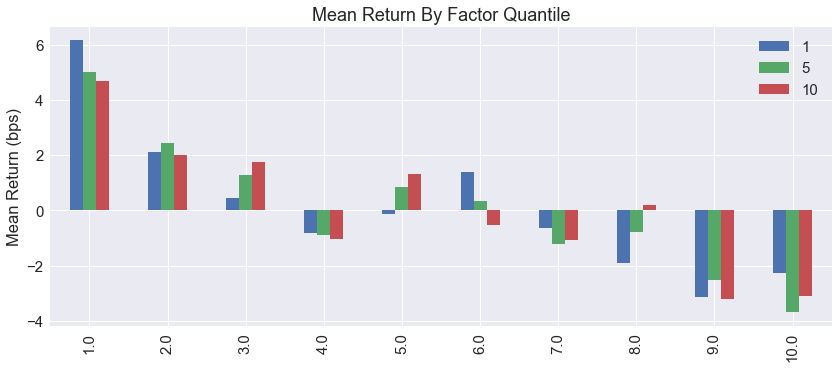

In [30]:
import alphalens

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(sp500_daily_rainfall_3mo_stack,
                                                                   pricing_test,
                                                                   quantiles=None,
                                                                   bins=np.arange(0, 1.1, 0.1))
alphalens.tears.create_summary_tear_sheet(factor_data)

## Backtesting with zipline

Backtesting with zipline is very similar to backtesting on [Quantopian](https://www.quantopian.com/). One can schedule functions to run daily weekly, etc. in `initialize`. Here, the `trade` function is scheduled to run at the start of each week, shorting the names where it has rained heavily at the headquarters in the past quarter, and buying the names where it has rained little at the headquarters in the past quarter.

More specifically, we are shorting the names where our normalized "quarterly raininess" signal is greater than 85%, and buying names where the signal is less than 15%. There isn't a specified number of holdings, but our gross leverage is fixed at 1.0.

In [21]:
import zipline
from zipline.algorithm import TradingAlgorithm
from zipline.finance import commission, slippage
from zipline.api import (order_target_percent, symbol, schedule_function, date_rules,
                         get_datetime, set_commission, set_slippage)


def initialize(context):
    context.short_threshold = 0.85
    context.long_threshold = 0.15
    context.gross_leverage = 1.0

    # Zero transaction cost
    set_commission(commission.PerShare(cost=0, min_trade_cost=0))
    set_slippage(slippage.FixedSlippage(spread=0.0))

    schedule_function(trade, date_rules.week_start())
    context.prev_holdings = set()

def trade(context, data):
    current_date = get_datetime().tz_localize(None).normalize()
    todays_sp500_rainfall = sp500_daily_rainfall_3mo.loc[current_date].copy()
    
    todays_sp500_rainfall = todays_sp500_rainfall.sort_values(ascending=True)
    
    longs = []
    shorts = []
    for stock, rainfall in todays_sp500_rainfall.items():
        if stock not in pricing.loc[current_date].dropna():
            continue
        if rainfall <= context.long_threshold:
            longs.append(stock)
        elif rainfall >= context.short_threshold:
            shorts.append(stock)

    for stock in longs:
        order_target_percent(symbol(stock), context.gross_leverage * 0.5  / len(longs))
    for stock in shorts:
        order_target_percent(symbol(stock), -context.gross_leverage * 0.5  / len(shorts))

    # Close previous positions
    for stock in context.prev_holdings:
        if stock not in longs and stock not in shorts:
            order_target_percent(symbol(stock), 0)

    context.prev_holdings = set(longs + shorts)

### Run the algorithm

In [22]:
start = '2015-01-01'
end = '2017-06-10'

results = zipline.run_algorithm(pd.Timestamp(start, tz='EST'), pd.Timestamp(end, tz='EST'),
                                initialize, 1e6, data=pricing.ffill())

## Analyzing backtest results with pyfolio

### In-sample testing

Pyfolio allows us to analyze the results of our zipline backtest. We can simply pass the `results` object into pyfolio, and it will generate a tear sheet for us. Performance metrics, position details, and transaction details are visible in this tear sheet. When developing the strategy, we'll continue to only work with our test (in-sample) pricing, so as not to contaminate the out-of-sample data we have saved.

From our results, we can see that the algorithm does well in-sample. The returns are fairly consistent, and the algorithm has a beta close to zero, indicating we are uncorrelated to the SPY benchmark. Our gross leverage is fixed around 1.0 while being market neutral, which is a highly desireable trait. Interestingly, the number of long and short holdings tend to fluctuate (this is fine, as long as our net dollar exposure stays close to zero).

Entire data start date: 2015-01-02
Entire data end date: 2016-12-30
Backtest months: 24


,Backtest
Annual return,9.2%
Cumulative returns,19.2%
Annual volatility,4.8%
Sharpe ratio,1.87
Calmar ratio,1.93
Stability,0.93
Max drawdown,-4.8%
Omega ratio,1.37
Sortino ratio,2.88
Skew,-0.09


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.78,2016-02-11,2016-04-27,2016-07-27,120
1,3.00,2016-10-27,2016-12-09,NaT,NaN
2,1.51,2015-02-03,2015-03-12,2015-04-01,42
3,1.32,2015-05-11,2015-05-21,2015-06-18,29
4,1.02,2015-08-07,2015-08-24,2015-10-15,50


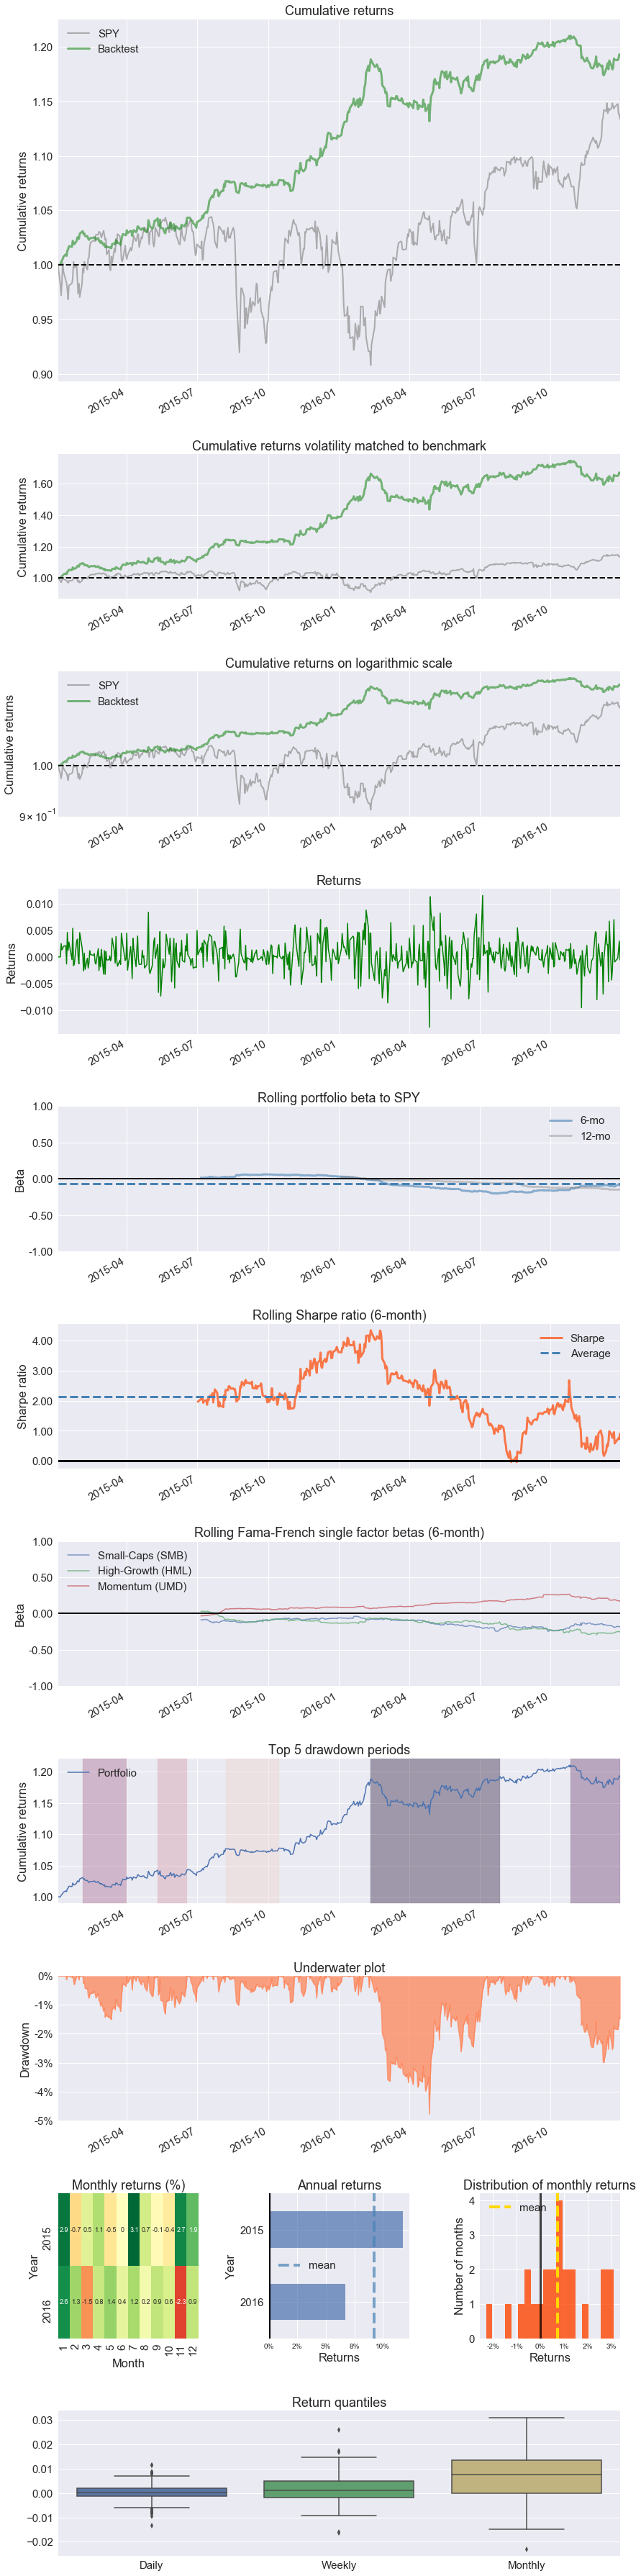

Stress Events,mean,min,max
Fall2015,-0.01%,-0.38%,0.52%
New Normal,0.04%,-1.32%,1.16%


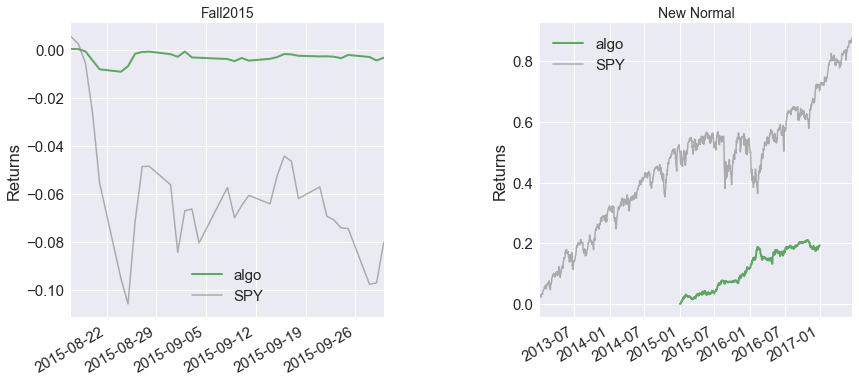

Top 10 long positions of all time,max
GRMN,8.75%
AMGN,8.61%
NEM,8.53%
MDT,8.50%
WLTW,8.46%
AON,8.38%
TE,8.33%
AIV,7.07%
WU,7.02%
DLPH,6.96%


Top 10 short positions of all time,max
APH,-50.15%
SNI,-25.44%
HUM,-16.72%
YUM,-16.71%
GRMN,-12.69%
MDT,-12.66%
TSCO,-8.58%
WIN,-8.53%
DG,-8.48%
FDO,-8.36%


Top 10 positions of all time,max
APH,50.15%
SNI,25.44%
HUM,16.72%
YUM,16.71%
GRMN,12.69%
MDT,12.66%
AMGN,8.61%
TSCO,8.58%
WIN,8.53%
NEM,8.53%


All positions ever held,max
APH,50.15%
SNI,25.44%
HUM,16.72%
YUM,16.71%
GRMN,12.69%
MDT,12.66%
AMGN,8.61%
TSCO,8.58%
WIN,8.53%
NEM,8.53%


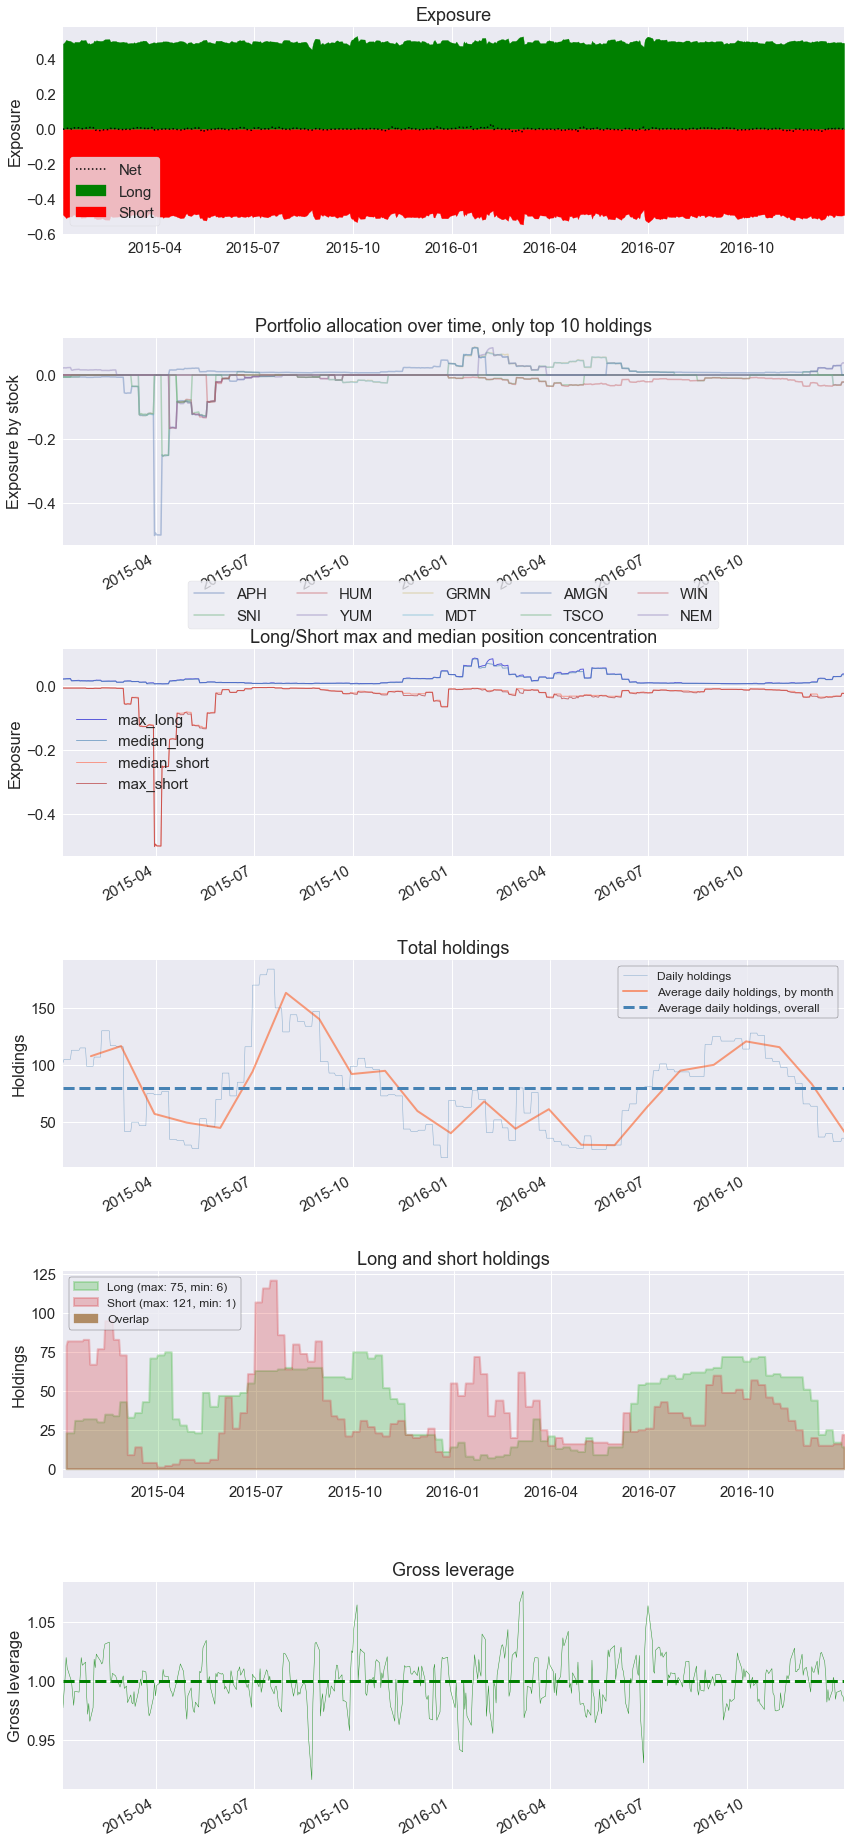

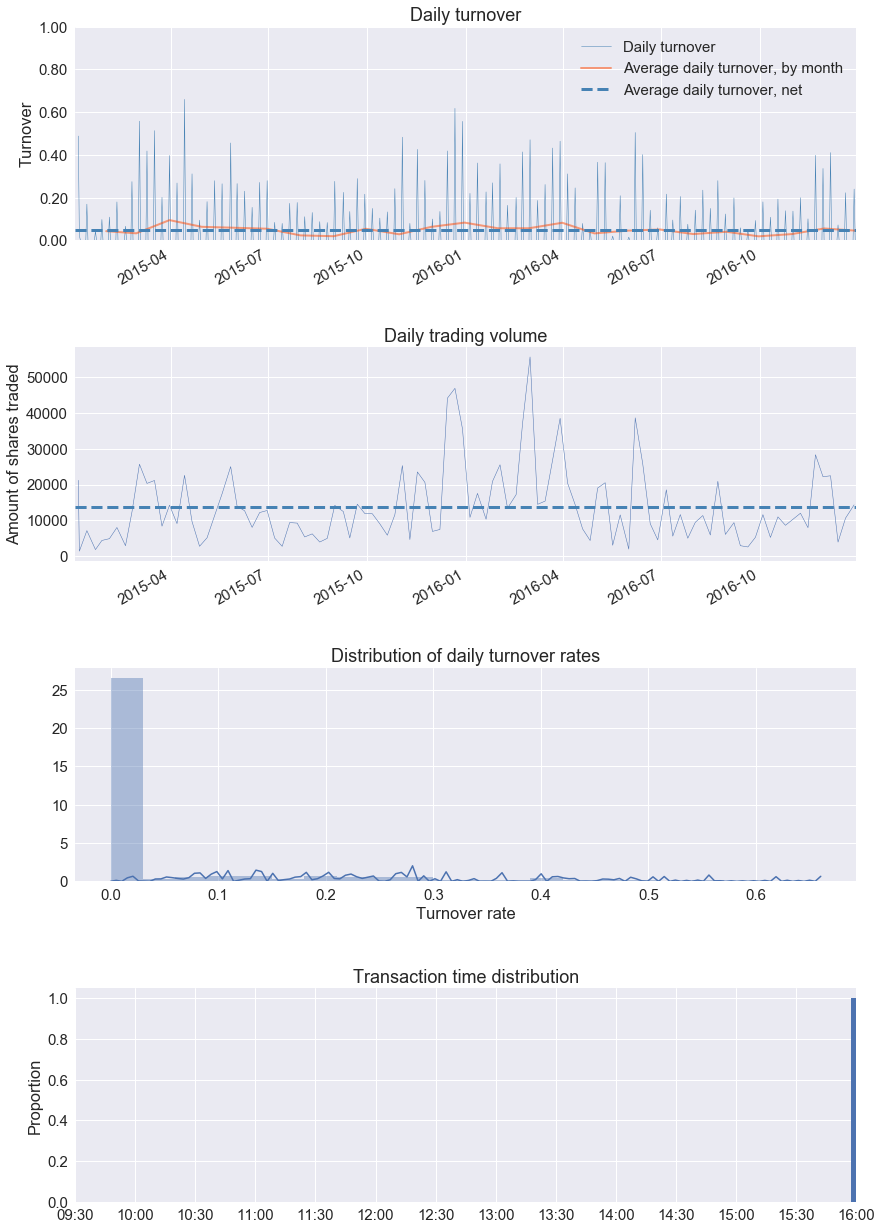

In [23]:
import pyfolio

pf_data = pyfolio.utils.extract_rets_pos_txn_from_zipline(results[:'2017-01-01'])
pyfolio.create_full_tear_sheet(*pf_data)

### Out-of-sample run

Now that we are nearing the end of development, we can run the out-of-sample test on the pricing data we witheld.

By passing `live_start_date`, pyfolio breaks out certain plots into in-sample and out-of-sample periods, where the in-sample period is the pricing data we tuned our alpha factor (rainfall) on.

Entire data start date: 2015-01-02
Entire data end date: 2017-06-09
In-sample months: 24
Out-of-sample months: 5


,All,In-sample,Out-of-sample
Annual return,9.2%,9.2%,9.5%
Cumulative returns,24.0%,19.2%,4.0%
Annual volatility,4.7%,4.8%,4.4%
Sharpe ratio,1.90,1.87,2.06
Calmar ratio,1.94,1.93,5.66
Stability,0.89,0.93,0.67
Max drawdown,-4.8%,-4.8%,-1.7%
Omega ratio,1.39,1.37,1.47
Sortino ratio,2.99,2.88,3.68
Skew,0.09,-0.09,1.13


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.78,2016-02-11,2016-04-27,2016-07-27,120
1,3.00,2016-10-27,2016-12-09,2017-05-01,133
2,1.51,2015-02-03,2015-03-12,2015-04-01,42
3,1.32,2015-05-11,2015-05-21,2015-06-18,29
4,1.02,2015-08-07,2015-08-24,2015-10-15,50


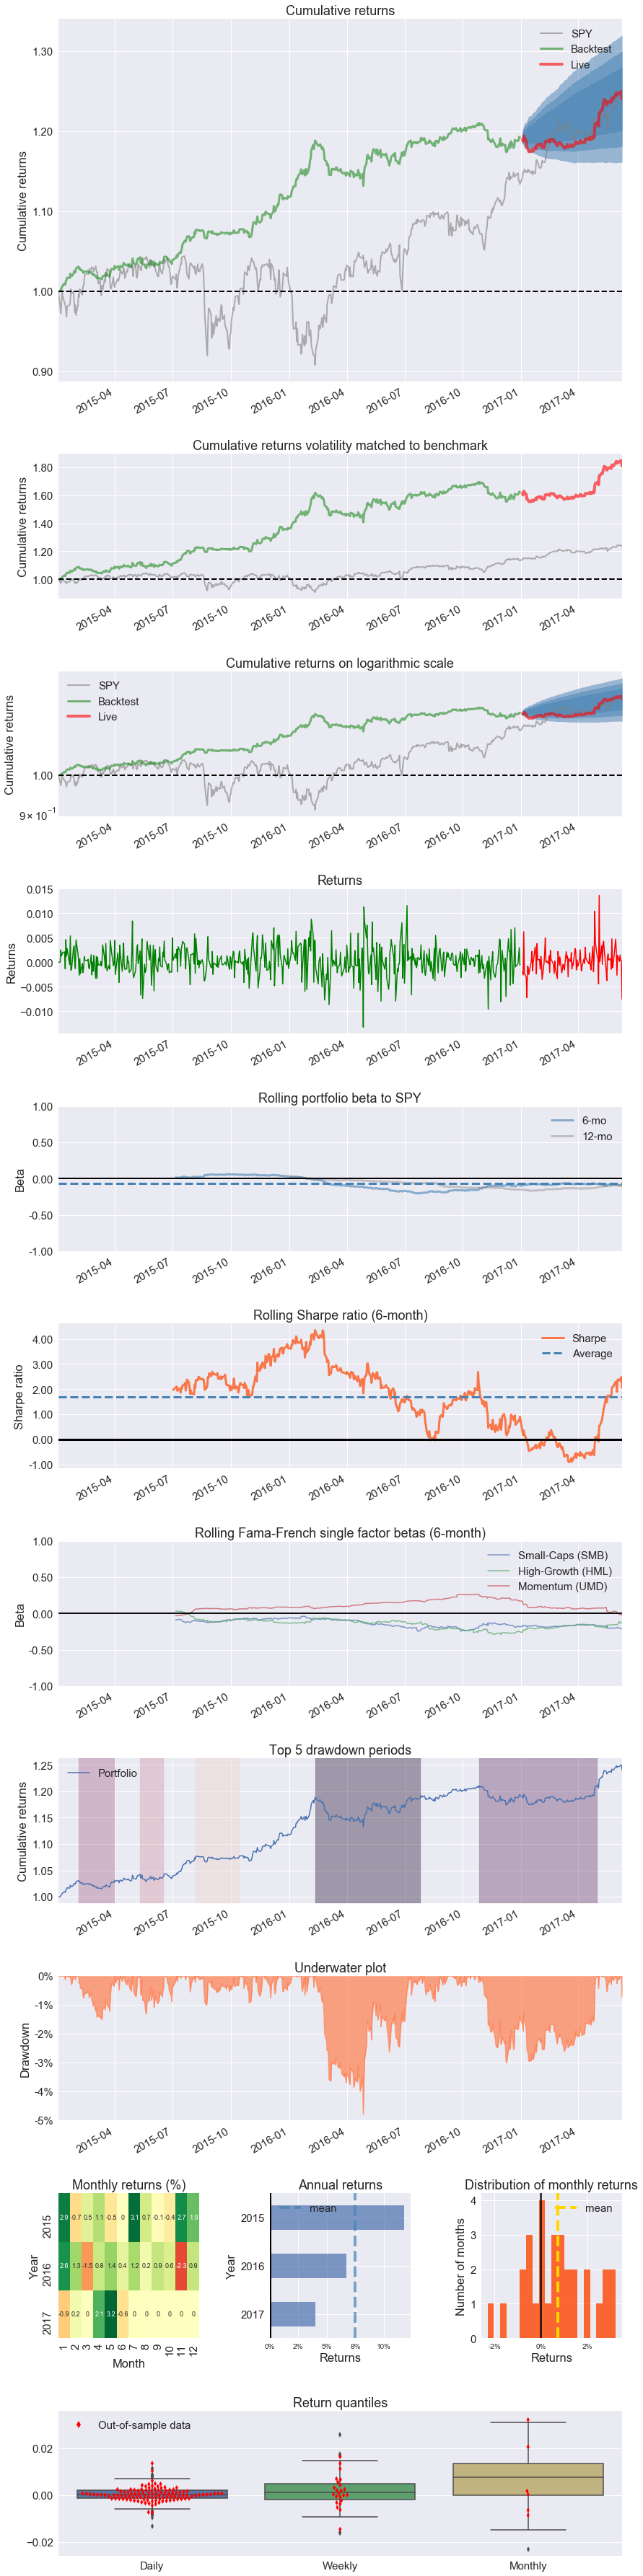

In [24]:
pf_data = pyfolio.utils.extract_rets_pos_txn_from_zipline(results)
pyfolio.create_returns_tear_sheet(pf_data[0], live_start_date='2017-01-01')

In the out-of-sample period, our performance fortunately holds up. This indicates that we have not overfit our algorithm. Even though the out-of-sample performance is good here, it may be wise to wait for additional out-of-sample data. Also note that, even though the strategy performed well in this period, it is impossible to say if the strategy will do well in the future, and once properties of the real market are taken into account.

Possible improvements to this algo?:
 * Increase the size and history of the universe to get a more significant backtest
 * Take other weather data like temperature into account
 * Play with parameters like the rolling average window
 * Consider the effects of slippage and commission
 * Etc.

## Thanks!
### Questions?

* Notebook can be found at https://github.com/gusgordon/open_source_trading_talk
* gus@quantopian.com
* @gusgordon